In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.4/904.4 kB 12.9 MB/s eta 0:00:00


In [ ]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

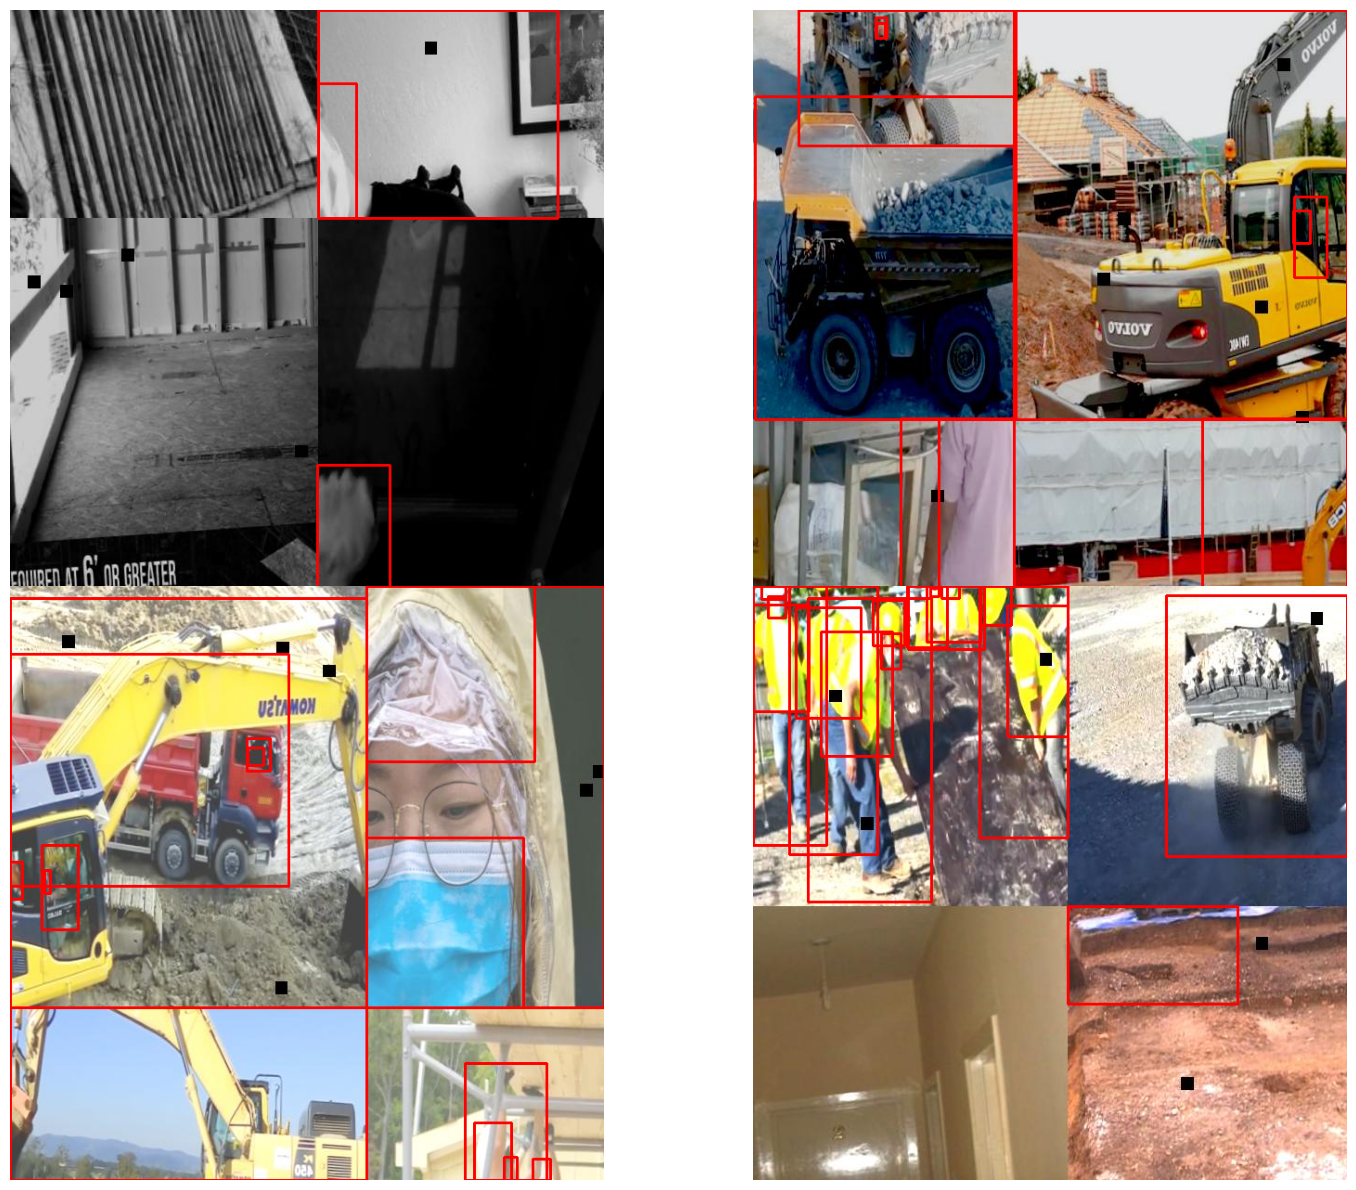

In [ ]:
# Visualize a few training images.
plot(
    image_paths='/content/drive/MyDrive/Construction Site Safety.v27-yolov8.yolov8/train/images/',
    label_paths='/content/drive/MyDrive/Construction Site Safety.v27-yolov8.yolov8/train/labels/',
    num_samples=4,
)

In [ ]:
%%writefile construction_v8.yaml
path: '/content/drive/MyDrive/Construction Site Safety.v27-yolov8.yolov8/'
train: 'train/images'
val: 'valid/images'

# class names
names:
  0: 'Hardhat'
  1: 'Mask'
  2: 'NO-Hardhat'
  3: 'NO-Mask'
  4: 'NO-Safety Vest'
  5: 'Person'
  6: 'Safety Cone'
  7: 'Safety Vest'
  8: 'machinery'
  9: 'vehicle'

Writing construction_v8.yaml


In [ ]:
EPOCHS = 25
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=construction_v8.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 6.25M/6.25M [00:00<00:00, 122MB/s]
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=construction_v8.yaml, epochs=25, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save

In [ ]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e/weights/best.pt name=yolov8n_eval data=construction_v8.yaml

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 944, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 146, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 289, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 910, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 837, in torch_safe_load
    ckpt = torch.load(fi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 1280x1280 1 Hardhat, 2 NO-Masks, 1 NO-Safety Vest, 3 Persons, 1101.8ms
Speed: 62.3ms preprocess, 1101.8ms inference, 33.7ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 5 Hardhats, 2 NO-Masks, 1 NO-Safety Vest, 3 Persons, 3 Safety Vests, 2 machinerys, 857.9ms
Speed: 19.1ms preprocess, 857.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 1 Safety Cone, 853.5ms
Speed: 23.5ms preprocess, 853.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 14 Hardhats, 3 NO-Hardhats, 5 NO-Masks, 12 NO-Safety Vests, 19 Persons, 8

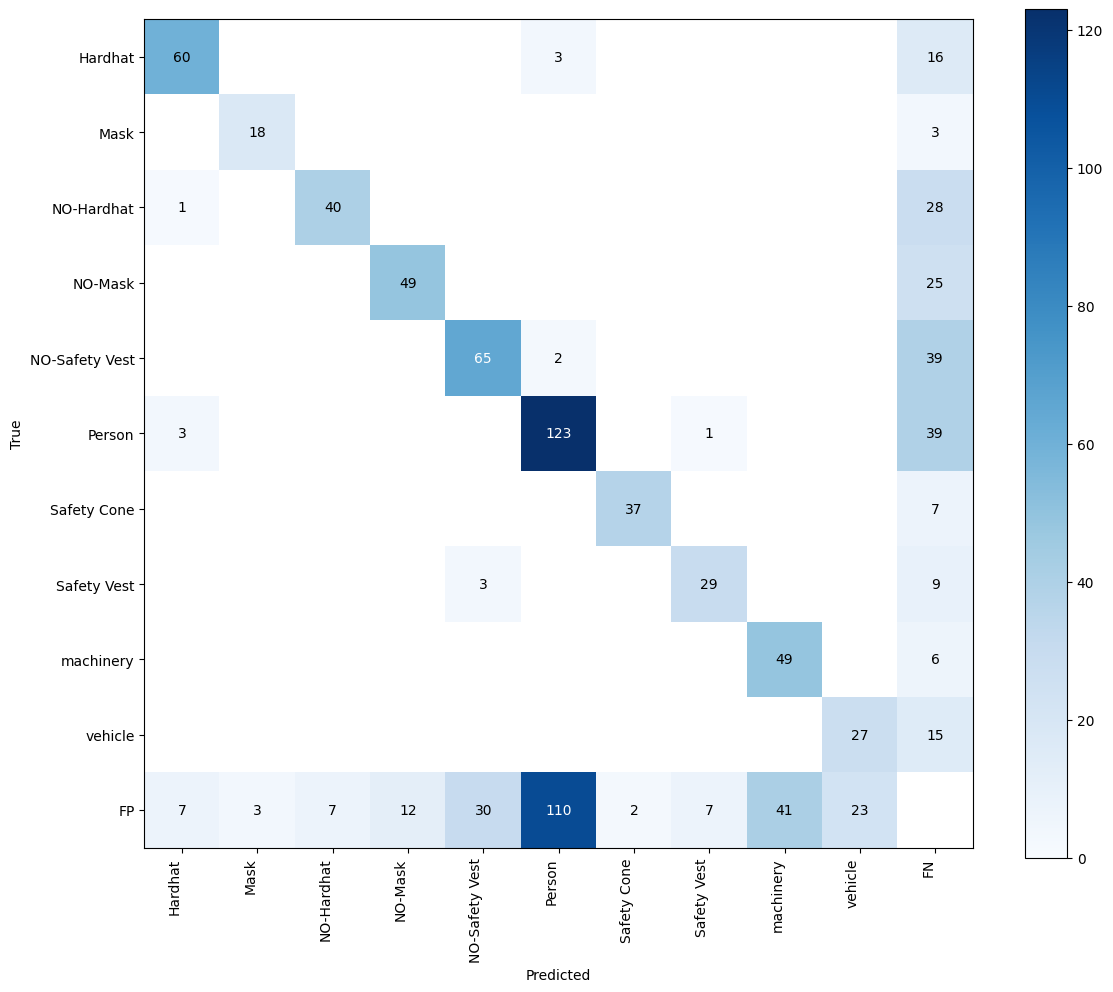

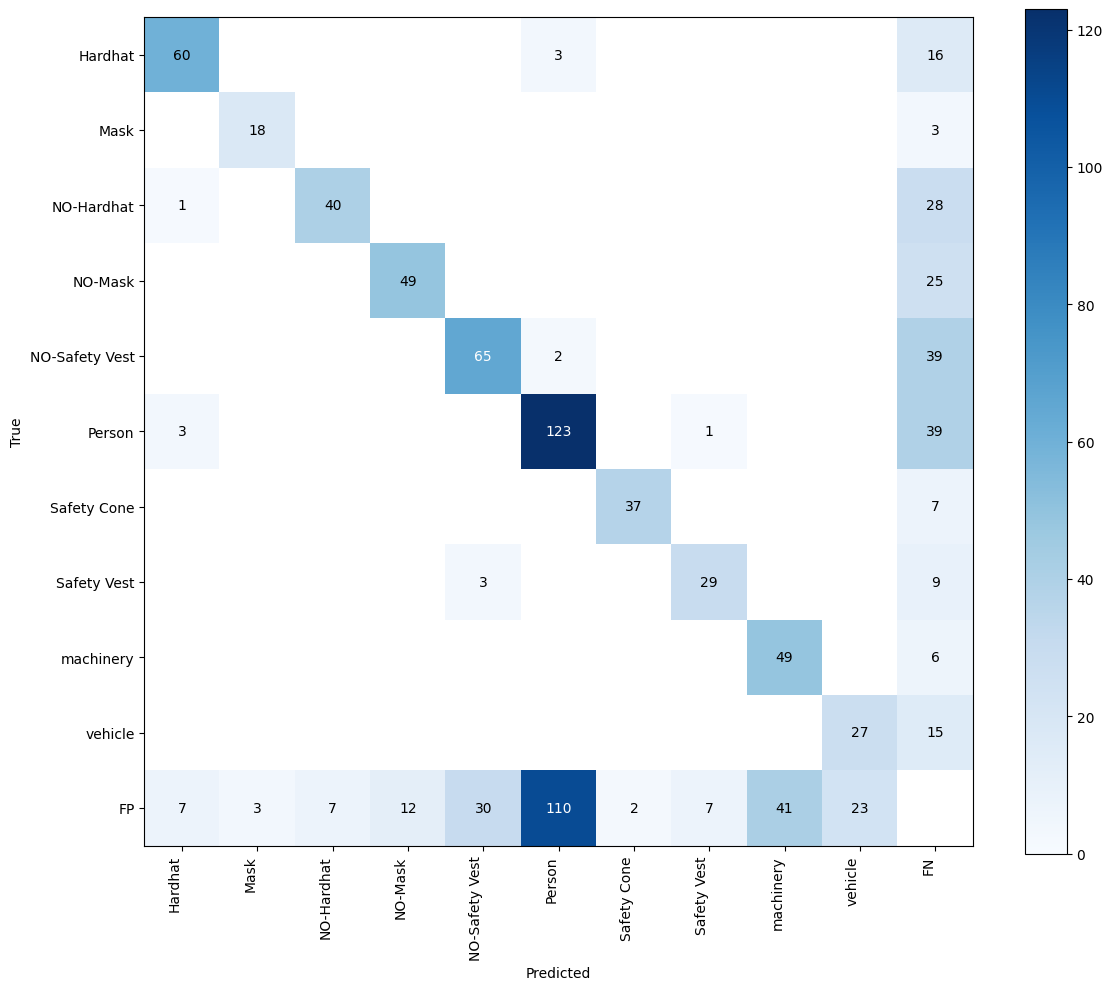

In [ ]:
!pip install supervision
import supervision as sv
from ultralytics import YOLO
import numpy as np

dataset = sv.DetectionDataset.from_yolo('/content/drive/MyDrive/Construction Site Safety.v27-yolov8.yolov8/valid/images', '/content/drive/MyDrive/Construction Site Safety.v27-yolov8.yolov8/valid/labels', '/content/construction_v8.yaml')

model = YOLO('/content/drive/MyDrive/runs/detect/yolov8n_v8_50e/weights/best.pt')
def callback(image: np.ndarray) -> sv.Detections:
    result = model(image)[0]
    return sv.Detections.from_ultralytics(result)

confusion_matrix = sv.ConfusionMatrix.benchmark(
   dataset = dataset,
   callback = callback
)

confusion_matrix.plot()